## Model Training

#### 1. Import Data and Required Packages
##### 1.1 Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [57]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

#### 1.2 Import the CSV Data as Pandas DataFrame

In [58]:
df = pd.read_csv("./data/calories.csv")
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


#### 1.3 Drop id column as it is statistically insignificant

In [59]:
df = df.drop(labels=['User_ID'],axis=1)

#### 1.4 Preparing X and Y variables

In [60]:
X = df.drop(labels=['Calories'],axis=1)
Y = df[['Calories']]

In [61]:
Y

,Calories
0,231.0
1,66.0
2,26.0
3,71.0
4,35.0
...,...
14995,45.0
14996,23.0
14997,75.0
14998,11.0


### 2. Creating Data Transformation Pipeline

#### 2.1 Creating Pipeline with Column Transformer

In [62]:
# Define which columns should be ordinal-encoded and which should be scaled
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns
            
# Define the custom ranking for each ordinal variable
Gender_categories = ['male', 'female']

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,StandardScaler

# Numerical Pipeline
num_pipeline = Pipeline(
                steps = [
                ('imputer',SimpleImputer(strategy='median')),
                ('scaler',StandardScaler())                
                ]
            )

# Categorical Pipeline
cat_pipeline = Pipeline(
                steps=[
                ('imputer',SimpleImputer(strategy='most_frequent')),
                ('ordinal_encoder',OrdinalEncoder(categories=[Gender_categories])),
                ('scaler',StandardScaler())
                ]
            )

preprocessor = ColumnTransformer(
                [
                ('num_pipeline',num_pipeline,numerical_cols),
                ('cat_pipeline',cat_pipeline,categorical_cols)
                ]
            )

### 2.2 Train Test Split

In [63]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.2,random_state=42)

In [64]:
print(f"X shape: {X.shape}")
print(f"X_train shape: {xtrain.shape}")
print(f"X_test shape: {xtest.shape}")

X shape: (15000, 7)
X_train shape: (12000, 7)
X_test shape: (3000, 7)


### 2.3 Transforming the data with pipeline created

In [65]:
xtrain = pd.DataFrame(preprocessor.fit_transform(xtrain),columns=preprocessor.get_feature_names_out())
xtest = pd.DataFrame(preprocessor.transform(xtest),columns=preprocessor.get_feature_names_out())

In [66]:
preprocessor.get_feature_names_out()

array(['num_pipeline__Age', 'num_pipeline__Height',
       'num_pipeline__Weight', 'num_pipeline__Duration',
       'num_pipeline__Heart_Rate', 'num_pipeline__Body_Temp',
       'cat_pipeline__Gender'], dtype=object)

In [67]:
xtrain.head()

,num_pipeline__Age,num_pipeline__Height,num_pipeline__Weight,num_pipeline__Duration,num_pipeline__Heart_Rate,num_pipeline__Body_Temp,cat_pipeline__Gender
0,-0.337295,0.323232,0.139551,-1.021889,-1.517377,-0.671031,-1.007193
1,-1.163322,1.447924,0.805955,1.266663,1.522425,0.614490,-1.007193
2,-0.573303,0.463818,0.139551,-0.419638,-0.783631,0.100281,-1.007193
3,1.373763,-1.293513,-1.393179,-0.780988,-1.936660,-0.671031,0.992859
4,-0.632304,-2.137032,-1.726381,-1.262789,-0.573990,-1.313791,0.992859


In [68]:
xtest.head()

,num_pipeline__Age,num_pipeline__Height,num_pipeline__Weight,num_pipeline__Duration,num_pipeline__Heart_Rate,num_pipeline__Body_Temp,cat_pipeline__Gender
0,0.134721,-1.434100,-1.526460,1.266663,1.207963,0.743042,0.992859
1,-1.281326,0.885578,1.005876,1.628014,1.627246,0.614490,-1.007193
2,0.901747,0.112352,0.139551,-0.540088,-0.573990,-0.028271,-1.007193
3,-0.455299,0.534112,0.939236,1.025763,1.312784,1.000146,-1.007193
4,1.432765,-0.239114,-0.526854,1.628014,2.151350,1.385802,0.992859


### 3. Model Training Baseline models

#### 3.1 Create an Evaluate Function to give all metrics after model Training

In [69]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

#### 3.2 Training Various models

In [70]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(xtrain, ytrain.values.flatten()) # Train model

    # Make predictions
    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 11.2670
- Mean Absolute Error: 8.3068
- R2 Score: 0.9672
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 11.4889
- Mean Absolute Error: 8.4415
- R2 Score: 0.9673


Lasso
Model performance for Training set
- Root Mean Squared Error: 12.2509
- Mean Absolute Error: 9.0094
- R2 Score: 0.9612
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 12.5619
- Mean Absolute Error: 9.1444
- R2 Score: 0.9609


Ridge
Model performance for Training set
- Root Mean Squared Error: 11.2670
- Mean Absolute Error: 8.3065
- R2 Score: 0.9672
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 11.4892
- Mean Absolute Error: 8.4412
- R2 Score: 0.9673


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 4.2902
- Mean Absolute Error: 3.1181
- R2 Score: 0.9952
-----------------

#### 3.3 Results

In [71]:
df_results = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
df_results

,Model Name,R2_Score
7,CatBoosting Regressor,0.999885
6,XGBRegressor,0.998868
5,Random Forest Regressor,0.998226
3,K-Neighbors Regressor,0.993518
4,Decision Tree,0.992899
0,Linear Regression,0.967294
2,Ridge,0.967292
8,AdaBoost Regressor,0.966096
1,Lasso,0.960899


### 4.Predictive Modeling Using Multiple Linear Regression

#### 4.1 Baseline Modeling

In [74]:
# Define independent variables (predictors) and dependent variable (target)
X_mlr = df[['Duration', 'Heart_Rate', 'Body_Temp', 'Age', 'Weight', 'Height']]
y_mlr = df['Calories']

# Initialize and fit the model
lr_model = LinearRegression()
lr_model.fit(X_mlr, y_mlr)

# Predictions
y_mlr_pred = lr_model.predict(X_mlr)

# Display results
print("Intercept:", lr_model.intercept_)
print("Coefficients:", lr_model.coef_)
print("R² Score:", r2_score(y_mlr, y_mlr_pred))
print("MSE:", mean_squared_error(y_mlr, y_mlr_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_mlr, y_mlr_pred)))

Intercept: 463.42924033852745
Coefficients: [  6.64055773   1.98956165 -16.97965224   0.50514786   0.24322886
  -0.15643565]
R² Score: 0.96716459666956
MSE: 128.07823514506518
RMSE: 11.317165508424146


#### 4.2 Feature Engineering for Better Prediction

In [75]:
# Feature Engineering
df["BMI"] = df["Weight"] / ((df["Height"] / 100) ** 2)   # Body Mass Index (BMI)
df["Duration_HeartRate"] = df["Duration"] * df["Heart_Rate"]   # Interaction between duration and heart rate
df["Weight_Age"] = df["Weight"] * df["Age"]    # Interaction between weight and age

# Define features and target
X_mlr_new = df[['Duration', 'Heart_Rate', 'Body_Temp', 'Age', 'Weight', 'Height',
            'BMI', 'Duration_HeartRate', 'Weight_Age']]
y_mlr_new = df['Calories']

# Fit the model
lr_model_new = LinearRegression()
lr_model_new.fit(X_mlr_new, y_mlr_new)

# Predict
y_mlr_pred_new = lr_model_new.predict(X_mlr_new)

# Results
print("Intercept:", lr_model_new.intercept_)
print("Coefficients:", lr_model_new.coef_)
print("R² Score:", r2_score(y_mlr_new, y_mlr_pred_new))
print("MSE:", mean_squared_error(y_mlr_new, y_mlr_pred_new))
print("RMSE:", np.sqrt(mean_squared_error(y_mlr_new, y_mlr_pred_new)))

Intercept: 292.46112306512896
Coefficients: [-7.28714494 -0.02986271  0.17334099 -0.37837965  1.52877761 -1.66466812
 -5.85051173  0.130594    0.01176053]
R² Score: 0.9867618896394833
MSE: 51.636759097116425
RMSE: 7.1858721876412766


By incorporating these new variables, I achieve:

- R² = 0.987, an improvement from 0.967.
- AIC/BIC values decrease, indicating a better model fit.
- Duration × Heart Rate (β = 0.1306, p < 0.001) emerges as the most important feature. These results confirm that workout intensity (heart rate) combined with duration is the best predictor of calorie burn. Other variables, like BMI and Weight × Age, also contribute but to a lesser extent.

#### R² has increased with the new features, but it is still less than the CatBoost model's performance. Therefore, the CatBoost model remains the preferred choice.

### 5. Hyperparameter tuning

#### 5.1 Tuning Catboost

In [47]:
# Initializing catboost
cbr = CatBoostRegressor(verbose=False)

# Creating the hyperparameter grid
param_dist = {'depth'          : [4,5,6,7,8,9, 10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
               'iterations'    : [300,400,500,600]}

#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbr , param_dist, scoring='r2', cv =5, n_jobs=-1)

# Fit the model
rscv.fit(xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

{'learning_rate': 0.04, 'iterations': 500, 'depth': 10}
0.9995974911450922


#### 5.1.1 Definition to print evaluated model results

In [48]:
def print_evaluated_results(model,xtrain,ytrain,xtest,ytest):
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, ytrain_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, ytest_pred)

    # Printing results
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))

In [49]:
# Selecting best model
best_cbr = rscv.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_cbr,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 0.6822
- Mean Absolute Error: 0.5205
- R2 Score: 0.9999
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.0152
- Mean Absolute Error: 0.6425
- R2 Score: 0.9997


#### 5.2 Tuning KNN

In [50]:
from sklearn.model_selection import GridSearchCV
# Initialize knn
knn = KNeighborsRegressor()

# parameters
k_range = list(range(2, 31))
param_grid = dict(n_neighbors=k_range)

# Fitting the cvmodel
grid = GridSearchCV(knn, param_grid, cv=5, scoring='r2',n_jobs=-1)
grid.fit(xtrain, ytrain)

# Print the tuned parameters and score
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 9}
0.992798491669476


In [51]:
# Selecting best model
best_knn = grid.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_knn,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 4.4717
- Mean Absolute Error: 3.2330
- R2 Score: 0.9948
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4.8757
- Mean Absolute Error: 3.5884
- R2 Score: 0.9941


#### 5.3 Tuning XGBoost

In [52]:
# Initializing xgboost
xgb = XGBRegressor()

# Parameters
params = {
 'learning_rate' : [0.01,0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
 'n_estimators':[300,400,500,600]
}

rs_xgb=RandomizedSearchCV(xgb,param_distributions=params,scoring='r2',n_jobs=-1,cv=5)
rs_xgb.fit(xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rs_xgb.best_params_)
print(rs_xgb.best_score_)

{'n_estimators': 400, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.15, 'gamma': 0.0, 'colsample_bytree': 0.7}
0.9992609722208622


In [53]:
# Selecting best xgb model
best_xgb = rs_xgb.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_xgb,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 1.0298
- Mean Absolute Error: 0.7592
- R2 Score: 0.9997
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.5522
- Mean Absolute Error: 1.1068
- R2 Score: 0.9994


### 6. Voting Regressor

In [54]:
from sklearn.ensemble import VotingRegressor

er = VotingRegressor([('cbr',best_cbr),('knn',best_knn),('xgb',XGBRegressor())], weights=[3,1,2])
er.fit(xtrain, ytrain.values.flatten())

print_evaluated_results(er,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 1.0063
- Mean Absolute Error: 0.7587
- R2 Score: 0.9997
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.3706
- Mean Absolute Error: 0.9543
- R2 Score: 0.9995


#### R² has increased with the Hyperparameter tuning & Ensembled Technique, but it is still less than the CatBoost model's performance. Therefore, the CatBoost model remains the preferred choice.

### 7. Catboost Model Analysis

#### 7.1 Feature Analysis

num_pipeline__Duration      51.661519
num_pipeline__Heart_Rate    21.845402
num_pipeline__Age           13.418052
num_pipeline__Body_Temp      6.723621
cat_pipeline__Gender         4.576183
num_pipeline__Weight         1.117946
num_pipeline__Height         0.657277
dtype: float64




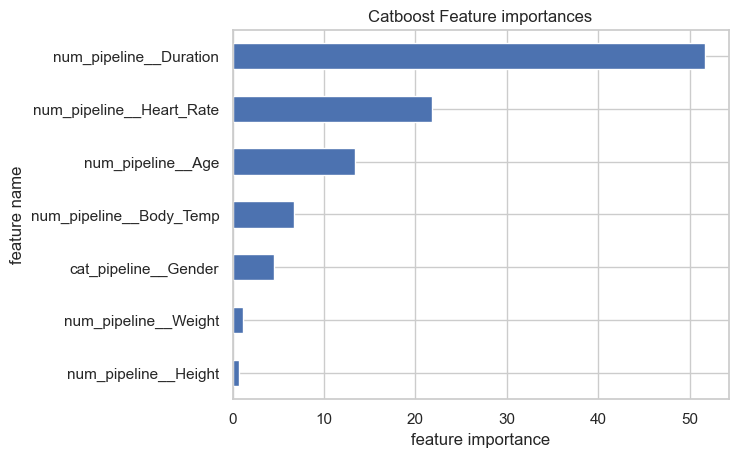

In [55]:
feature_imp = best_cbr.feature_importances_
feature_nm = best_cbr.feature_names_
imp_series = pd.Series(feature_imp)
imp_series.index = feature_nm
print(imp_series.sort_values(ascending=False))
print('\n')
imp_series.sort_values().plot(kind='barh',
                              xlabel='feature importance',
                              ylabel='feature name',
                              title='Catboost Feature importances')
plt.show()

#### 7.2 Ploting Actual vs Predicted

C:\Users\Anmol jain\AppData\Local\Temp\ipykernel_19580\1628312707.py:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Anmol jain\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


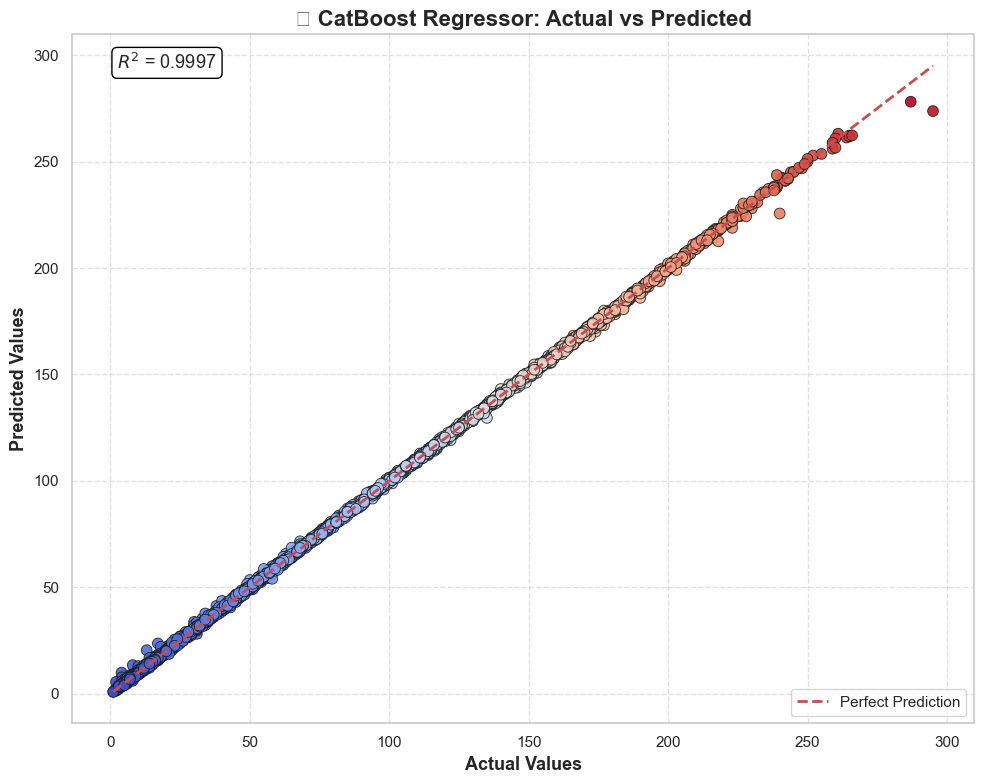

In [56]:
# Predict
y_pred = best_cbr.predict(xtest)
r2 = r2_score(ytest, y_pred)

# Set style
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(10, 8))
palette = sns.color_palette("coolwarm", as_cmap=True)

# Scatter plot with color gradient based on prediction value
sns.scatterplot(x=ytest.values.flatten(), y=y_pred,
                hue=y_pred, palette=palette, s=60, edgecolor='k', alpha=0.9, legend=False)

# Perfect prediction line
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()],
         'r--', lw=2, label='Perfect Prediction')

# Labels & Title
plt.xlabel("Actual Values", fontsize=13, weight='bold')
plt.ylabel("Predicted Values", fontsize=13, weight='bold')
plt.title("📈 CatBoost Regressor: Actual vs Predicted", fontsize=16, weight='bold')

# Annotate R²
plt.text(0.05, 0.95, f"$R^2$ = {r2:.4f}", transform=plt.gca().transAxes,
         fontsize=13, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Grid and layout
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
